In [204]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.linalg

plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 150

# 1D Chiral-p SC Band Structure

In [205]:
t = 1.0
mu_values = [-4 * t, 0.0, 4 * t]
delta = complex(1.0, 0.0)

ribbon_width = 20
H_k = (
    lambda k: 1.0
    / 2.0
    * np.array(
        [
            [-t * (np.cos(k[0]) + np.cos(k[1])) - 1.0 / 2.0 * mu, 0.0],
            [0.0, -t * (np.cos(k[0]) + np.cos(k[1])) - 1.0 / 2.0 * mu],
        ],
        dtype=complex,
    )
)
gap_fct = lambda k: np.array(
    [
        [0.0, delta * complex(np.sin(k[0]), np.sin(k[1]))],
        [delta * complex(np.sin(k[0]), np.sin(k[1])), 0.0],
    ],
    dtype=complex,
)
H_BdG = lambda k: np.block(
    [[H_k(k), gap_fct(k)], [gap_fct(k).conj().T, -H_k(-k).conj()]]
)
dim_H_BdG = 4

dim_H_ribbon = ribbon_width * dim_H_BdG

Mu values:  -4.0 0.0 4.0
2.0


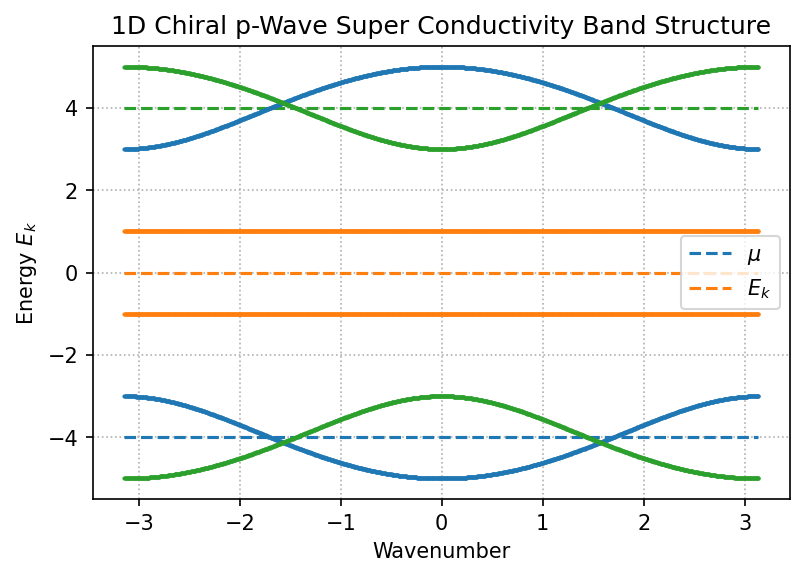

In [206]:
print("Mu values: ", *mu_values)
num_sites = 1000
degeneracy = 2
wave_vectors = [
    np.array([2.0 * np.pi * (k - num_sites // 2) / num_sites]) for k in range(num_sites)
]
chiral_spectrum = lambda k: np.sqrt(
    np.abs(delta) ** 2 * np.linalg.norm(np.sin(k), ord=2) ** 2
    + (np.sum(np.cos(k)) - mu) ** 2
)

print(np.sum(np.cos(np.array([0, 0]))))

plt.grid(linestyle=":", zorder=-10)
for mu in mu_values:
    energies = [chiral_spectrum(k) for k in wave_vectors]
    plt.xlabel("Wavenumber")
    plt.ylabel("Energy $E_k$")
    plt.scatter(
        [k[0] for k in wave_vectors for _ in range(degeneracy)],
        [(-1) ** s * energy for energy in energies for s in range(degeneracy)],
        s=1.0,
        zorder=10,
    )
    plt.plot(wave_vectors, [mu for k in range(num_sites)], "--", zorder=5)
    plt.title("1D Chiral p-Wave Super Conductivity Band Structure")
    plt.legend([r"$\mu$", r"$E_k$"])

# 2D Chiral-p SC Band Structure

/Users/isidorschoch/opt/miniconda3/envs/numerics/lib/python3.9/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


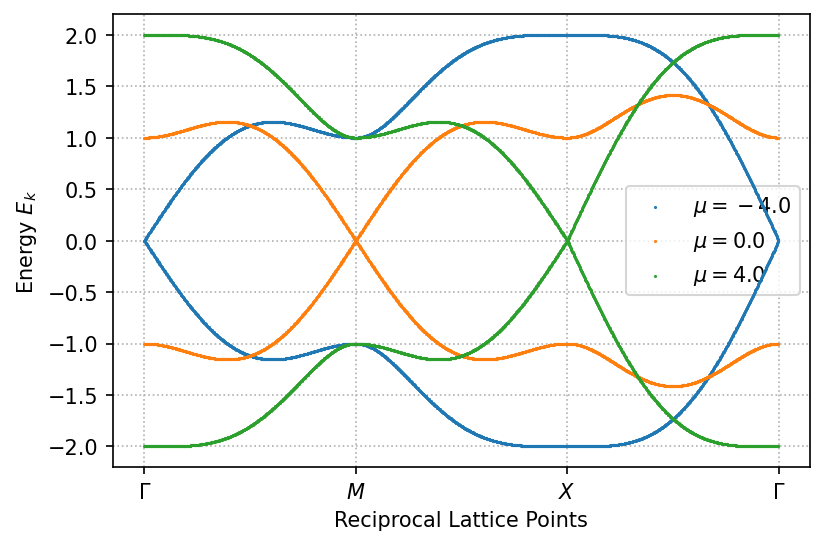

In [207]:
for mu in mu_values:
    wave_vectors_2d = []
    for i in range(num_sites // 2):
        wave_vectors_2d.append(np.array([2.0 * np.pi * i / num_sites, 0]))

    for i in range(num_sites // 2):
        wave_vectors_2d.append(np.array([np.pi, 2.0 * np.pi * i / num_sites]))

    for i in range(num_sites // 2):
        wave_vectors_2d.append(
            np.array(
                [
                    2.0 * np.pi * (num_sites // 2 - i) / num_sites,
                    2.0 * np.pi * (num_sites // 2 - i) / num_sites,
                ]
            )
        )

    # energies_2d = [chiral_spectrum(k) for k in wave_vectors_2d]
    energies_2d = [scipy.linalg.eigvals(H_BdG(k))[0] for k in wave_vectors_2d]

    ax = plt.gca()
    ax.set_xticks(range(0, 3 * num_sites // 2 + 1, num_sites // 2))
    plt.xticks(
        range(0, 3 * num_sites // 2 + 1, num_sites // 2),
        [r"$\Gamma$", r"$M$", r"$X$", r"$\Gamma$"],
    )
    plt.xlabel("Reciprocal Lattice Points")
    plt.ylabel("Energy $E_k$")
    plt.grid(linestyle=":", zorder=-10)
    plt.scatter(
        [itr for (itr, k) in enumerate(wave_vectors_2d) for _ in range(degeneracy)],
        [(-1) ** s * energy for energy in energies_2d for s in range(degeneracy)],
        marker=".",
        s=1.0,
        zorder=10,
    )
    # plt.plot(
    #     [itr for (itr, k) in enumerate(wave_vectors_2d)],
    #     [mu for k in wave_vectors_2d],
    #     "--",
    # )
    # plt.title("2D Square Lattice Chiral p-Wave Super Conductivity Band Structure")
    # plt.legend([r"$\mu$", r"$E_k$"])
plt.legend(
    [f"$\mu = {mu_values[0]}$", f"$\mu = {mu_values[1]}$", f"$\mu = {mu_values[2]}$"]
)

plt.savefig("./plots/band_structure_2d.svg")

# Ribbon Geometry Simulation

## Band Structure

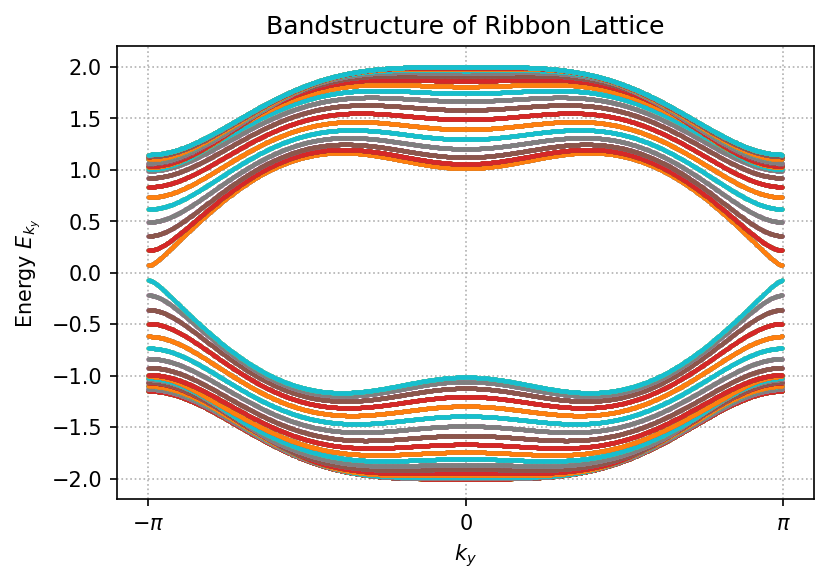

In [208]:
def get_H_BdG_tilde(k_y, neighbour):
    result = np.zeros(shape=(dim_H_BdG, dim_H_BdG), dtype=complex)
    for k_x in [2.0 * np.pi * k / ribbon_width for k in range(ribbon_width)]:
        result += (
            1.0
            / ribbon_width
            * H_BdG(np.array([k_x, k_y]))
            * np.exp(neighbour * complex(0.0, 1.0) * k_x)
        )
    return result


energies_ribbon = np.zeros(shape=(num_sites, dim_H_ribbon))
wave_fcts = np.zeros(shape=(num_sites, dim_H_ribbon, dim_H_ribbon), dtype=complex)
wave_vectors_ky_values = [2.0 * np.pi * k / num_sites - np.pi for k in range(num_sites)]
for itr, k_y in enumerate(wave_vectors_ky_values):
    H_ribbon = np.zeros(shape=(dim_H_ribbon, dim_H_ribbon), dtype=complex)
    H_BdG_tilde = get_H_BdG_tilde(k_y, 0)
    H_BdG_tilde_R = get_H_BdG_tilde(k_y, -1)
    H_BdG_tilde_L = get_H_BdG_tilde(k_y, +1)

    H_ribbon[0:dim_H_BdG, 0:dim_H_BdG] = H_BdG_tilde
    H_ribbon[0:dim_H_BdG, dim_H_BdG : 2 * dim_H_BdG] = H_BdG_tilde_R

    for idx in range(1, ribbon_width - 1):
        H_ribbon[
            idx * dim_H_BdG : (idx + 1) * dim_H_BdG,
            idx * dim_H_BdG : (idx + 1) * dim_H_BdG,
        ] = H_BdG_tilde
        H_ribbon[
            idx * dim_H_BdG : (idx + 1) * dim_H_BdG,
            (idx + 1) * dim_H_BdG : (idx + 2) * dim_H_BdG,
        ] = H_BdG_tilde_R
        H_ribbon[
            idx * dim_H_BdG : (idx + 1) * dim_H_BdG,
            (idx - 1) * dim_H_BdG : idx * dim_H_BdG,
        ] = H_BdG_tilde_L

    H_ribbon[
        (ribbon_width - 1) * dim_H_BdG : ribbon_width * dim_H_BdG,
        (ribbon_width - 1) * dim_H_BdG : ribbon_width * dim_H_BdG,
    ] = H_BdG_tilde
    H_ribbon[
        (ribbon_width - 1) * dim_H_BdG : ribbon_width * dim_H_BdG,
        (ribbon_width - 2) * dim_H_BdG : (ribbon_width - 1) * dim_H_BdG,
    ] = H_BdG_tilde_L

    # periodic BC
    # H_ribbon[0:dim_H_BdG, (ribbon_width-1) * dim_H_BdG: ribbon_width*dim_H_BdG] = H_BdG_tilde_L
    # H_ribbon[(ribbon_width-1)*dim_H_BdG:ribbon_width*dim_H_BdG, 0: dim_H_BdG] = H_BdG_tilde_R

    energies_ribbon[itr, :], wave_fcts[itr, :, :] = scipy.linalg.eigh(H_ribbon)

plt.xticks([-np.pi, 0.0, np.pi], [r"$-\pi$", r"0", r"$\pi$"])
plt.xlabel(r"$k_{y}$")
plt.ylabel(r"Energy $E_{k_{y}}$")
plt.grid(linestyle=":", zorder=-10)
plt.title("Bandstructure of Ribbon Lattice")
for idx in range(dim_H_ribbon):
    plt.scatter(wave_vectors_ky_values, energies_ribbon[:, idx], s=1.0, zorder=10)

## Wavefunction

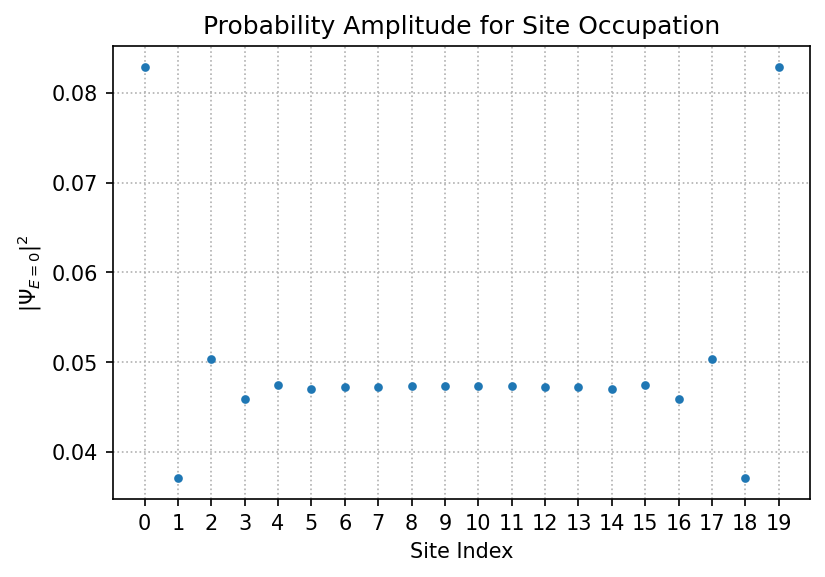

In [209]:
zero_energy_indices = np.unravel_index(
    np.abs(energies_ribbon).argmin(), energies_ribbon.shape
)
zero_energy_prob_amplitude = np.zeros(ribbon_width, dtype=float)

for i in range(ribbon_width):
    for j in range(dim_H_BdG):
        zero_energy_prob_amplitude[i] += (
            np.abs(
                wave_fcts[
                    zero_energy_indices[0], i * dim_H_BdG + j, zero_energy_indices[1]
                ]
            )
            ** 2
        )
ax = plt.gca()
ax.set_xticks(range(0, ribbon_width, ribbon_width // min(ribbon_width, 20)))
plt.ylabel(r"$|\Psi_{E=0}|^{2}$")
plt.xlabel("Site Index")

plt.title("Probability Amplitude for Site Occupation")
plt.grid(linestyle=":", zorder=-10)
plt.scatter(
    range(len(zero_energy_prob_amplitude)), zero_energy_prob_amplitude, s=10, zorder=10
)